In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
import seaborn as sns
from rdkit.Chem import CanonSmiles
from tqdm.auto import tqdm

sns.set(context="talk", style="ticks", color_codes=True, rc={"legend.frameon": False})


logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog("rdApp.error")
tqdm.pandas()

%matplotlib inline

In [2]:
data = pd.read_csv("220629_dupl_rmvd.csv")
data = data[~data.No.isin([48, 199, 1155, 517, 518, 931])]

In [3]:
data = data[data["Mole/Weight/Volume Fraction"] == "mole"]

In [4]:
blends = data[
    [
        "No",
        "Mole/Weight/Volume Fraction",
        "CN",
        "DCN or ICN",
        "Method",
        "Device",
        "Comments",
        "Reference",
    ]
]

In [5]:
blends["Mole/Weight/Volume Fraction"].value_counts()

mole    1222
Name: Mole/Weight/Volume Fraction, dtype: int64

In [6]:
smiles = data.melt(
    id_vars="No",
    value_vars=data.columns[data.columns.str.startswith("smi_mol")],
    value_name="SMILES",
)
m_conc = data.melt(
    id_vars="No",
    value_vars=data.columns[data.columns.str.startswith("x_mol")],
    value_name="mol_pct",
)


def try_canon_smiles(x):
    try:
        return CanonSmiles(x)
    except Exception:
        return None


smiles["SMILES"] = smiles.SMILES.apply(try_canon_smiles)
smiles["mol_pct"] = m_conc["mol_pct"]
fuel_comp = smiles.drop("variable", axis=1)

In [7]:
fuel_comp = (
    fuel_comp.dropna()
    .sort_values(["No", "mol_pct"], ascending=[True, False])
    .reset_index(drop=True)
)

assert np.allclose(m_conc.groupby("No").sum(), 1.0, atol=0.01)
fuel_comp.head()

,No,SMILES,mol_pct
0,4,CCCCCCCCCC,0.796
1,4,Cc1ccccc1,0.204
2,5,CCCCCCCCCC,0.592
3,5,Cc1ccccc1,0.408
4,6,Cc1ccccc1,0.804


In [8]:
fuel_comp.SMILES.isna().any()

False

In [9]:
len(fuel_comp.SMILES.unique())

428

In [10]:
X = fuel_comp.pivot(columns="SMILES", index="No", values="mol_pct").fillna(0.0)

blends = blends.set_index("No").reindex(X.index)
y = blends.CN

In [11]:
import sklearn
from sklearn.linear_model import LinearRegression

In [12]:
reg = LinearRegression().fit(X, y)

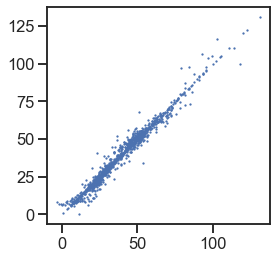

In [13]:
plt.figure(figsize=(4, 4))
plt.plot(reg.predict(X), y, ".", ms=2.5)

In [14]:
blends["reg_err"] = reg.predict(X) - y

In [15]:
blends.sort_values("reg_err")

,Mole/Weight/Volume Fraction,CN,DCN or ICN,Method,Device,Comments,Reference,reg_err
No,,,,,,,,
504,mole,97.20,DCN,ASTM D6890,IQT,NaN,20,-18.333321
795,mole,41.00,DCN,ASTM D6890,IQT,NaN,41,-17.404549
608,mole,67.83,DCN,ASTM D6890,IQT,NaN,25,-16.482240
115,mole,52.00,CN,NaN,NaN,Converted from weight ratio to mole ratio. Th...,5,-15.477990
497,mole,106.20,DCN,ASTM D6890,IQT,NaN,20,-13.866278
...,...,...,...,...,...,...,...,...
996,mole,6.00,DCN,ASTM D6890,IQT,NaN,16,11.152499
1007,mole,0.00,DCN,ASTM D613,By definition,NaN,55,11.463970
945,mole,72.90,DCN,ASTM D6890,IQT,NaN,53,12.054442


In [16]:
sklearn.metrics.mean_absolute_error(reg.predict(X), y)

1.8573646700218462

In [17]:
num_comps = fuel_comp.No.value_counts()
binary_blends = blends[blends.index.isin(num_comps[num_comps == 2].index)]

In [18]:
blends["components"] = fuel_comp.groupby("No").apply(
    lambda df: tuple(sorted(df.SMILES))
)

In [19]:
binary_blends = blends[blends.components.apply(len) == 2].components.value_counts()

In [20]:
blends[blends.components == ('CCCCCCC', 'Cc1ccccc1')].merge(fuel_comp[fuel_comp.SMILES == 'CCCCCCC'], right_on="No", left_index=True).sort_values("mol_pct")

,Mole/Weight/Volume Fraction,CN,DCN or ICN,Method,Device,Comments,Reference,reg_err,components,No,SMILES,mol_pct
1762,mole,19.84,DCN,ASTM D6890,IQT,NaN,22,6.064148,"(CCCCCCC, Cc1ccccc1)",536,CCCCCCC,0.237
1760,mole,22.93,DCN,ASTM D6890,IQT,NaN,22,4.598926,"(CCCCCCC, Cc1ccccc1)",535,CCCCCCC,0.281
1758,mole,25.80,DCN,ASTM D6890,IQT,NaN,22,3.390632,"(CCCCCCC, Cc1ccccc1)",534,CCCCCCC,0.326
1756,mole,28.62,DCN,ASTM D6890,IQT,NaN,22,2.269264,"(CCCCCCC, Cc1ccccc1)",533,CCCCCCC,0.372
1754,mole,30.98,DCN,ASTM D6890,IQT,NaN,22,1.681750,"(CCCCCCC, Cc1ccccc1)",532,CCCCCCC,0.420
1752,mole,33.75,DCN,ASTM D6890,IQT,NaN,22,0.758089,"(CCCCCCC, Cc1ccccc1)",531,CCCCCCC,0.470
1749,mole,36.74,DCN,ASTM D6890,IQT,NaN,22,-0.348645,"(CCCCCCC, Cc1ccccc1)",530,CCCCCCC,0.521
2167,mole,31.00,DCN,ASTM D6890,IQT,NaN,27,5.686770,"(CCCCCCC, Cc1ccccc1)",634,CCCCCCC,0.529


In [21]:
binary_blends[binary_blends >= 5]

(CC(C)CC(C)(C)C, CCCCCCCCCCCC)                    17
(CC(C)CC(C)(C)C, CCCCCCC)                         13
(CCO, CCOCC)                                      12
(CC(C)CC(C)(C)C, CCCCCCCCCC)                      11
(CCCCCCC, CCCCO)                                  10
(C1CCCCC1, CC(C)CC(C)(C)C)                         9
(CC(C)CC(C)(C)C, c1ccc2c(c1)CCCC2)                 9
(C=CCCCC, CC(C)CC(C)(C)C)                          9
(CCCCCCC, c1ccoc1)                                 8
(CC1CCCO1, CCCCCCC)                                8
(CCCCCCC, Cc1ccccc1)                               8
(CCCCCCC, CCO)                                     7
(CCCCCCC, Cc1ccco1)                                7
(CC(C)(C)O, CCCCCCC)                               7
(CCCCCCC, Cc1ccc(C)o1)                             7
(CCCCCCCCCCCCCCCC, Cc1ccccc1)                      7
(CC(CC(C)(C)C)CC(C)(C)CC(C)(C)C, CCCCCCCCCCCC)     6
(CCC1CCCO1, CCCCCCC)                               6
(CC(C)CO, CCCCCCC)                            

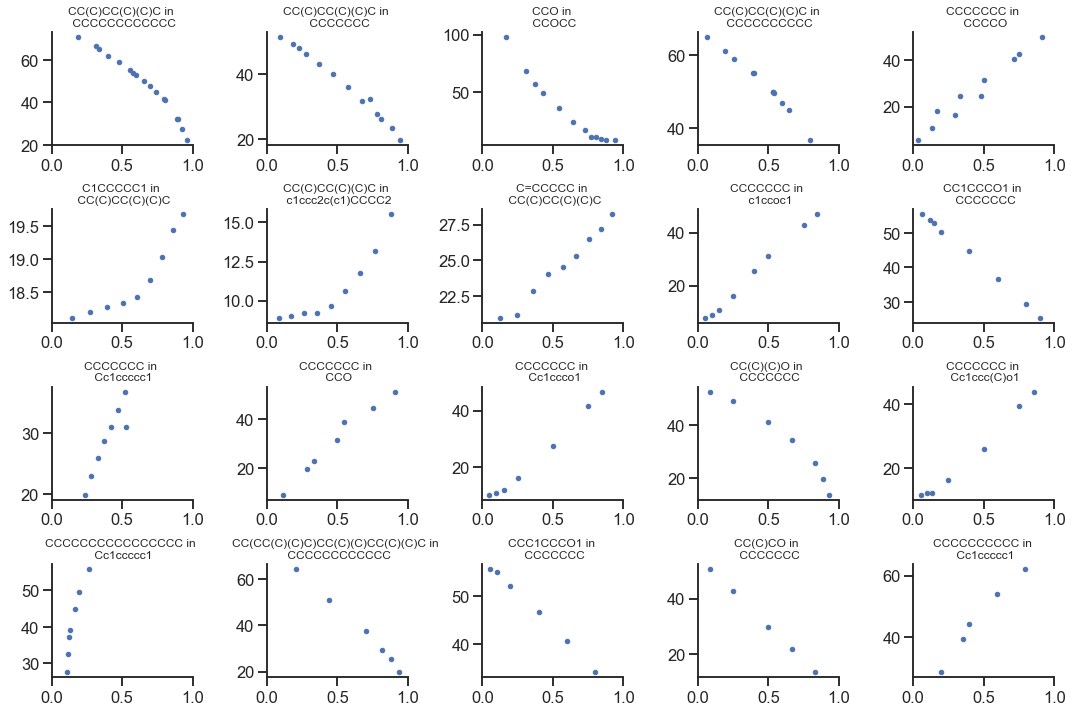

In [24]:
fig, axmatrix = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))

for smiles, ax in zip(binary_blends[binary_blends >= 5].index, axmatrix.flatten()):
    
    df = (
        blends[blends.components == smiles]
        .merge(fuel_comp[fuel_comp.SMILES == smiles[0]], right_on="No", left_index=True)
        .sort_values("mol_pct")
    )
    
    ax.set_title(f"{smiles[0]} in \n {smiles[1]}", fontsize=12)
    
    ax.plot(df.mol_pct, df.CN, ".")
    ax.set_xlim([0, 1])
    
sns.despine()
plt.tight_layout()